# 번역기 만들기 (단어수준)

In [1]:
import os
import re
import pandas as pd
import numpy as np
import unicodedata

# tensorflow version : 2.6.0
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

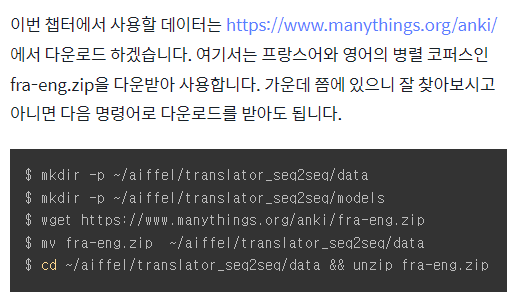

## Step 1. Data (정제, 정규화, 전처리)

In [2]:
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')

lines = lines[['eng', 'fra']][:33000] # 3만3천개 샘플 사용
lines.sample(5)

,eng,fra
5267,I'm not rich.,Je ne suis pas riche.
5358,I've got you.,Je vous ai eue.
30786,It's not that deep.,Ce n'est pas si profond.
15575,That is a table.,C'est une table.
12957,Are you dressed?,Es-tu habillé ?


In [3]:
def to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

In [4]:
# data 전처리
def preprocess_sentence(sentence):
    sentence = to_ascii(sentence.lower()) # 프랑스어 악센트삭제
    sentence = sentence.lower().strip() # 1 소문자로 바꾸고 양쪽 공백 지우기
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2  특수문자(구두점) 양쪽에 공백을 넣기
    sentence = re.sub(r'[" "]+', " ", sentence) # 3 여러개의 공백은 하나의 공백으로 바꾸기
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기
    sentence = sentence.strip() # 5 다시 양쪽 공백을 지우기
    sentence = sentence.split(" ")
    
    return sentence

In [5]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : ['have', 'you', 'had', 'dinner', '?']
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : ['avez', 'vous', 'deja', 'dine', '?']


## Step 2. 디코더의 문장에 시작 토큰과 종료 토큰 추가

In [6]:
# data 전처리
def preprocess_sentence_deconder(sentence):
    sentence = to_ascii(sentence.lower()) # 프랑스어 악센트삭제
    sentence = sentence.lower().strip() # 1 소문자로 바꾸고 양쪽 공백 지우기
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2  특수문자(구두점) 양쪽에 공백을 넣기
    sentence = re.sub(r'[" "]+', " ", sentence) # 3 여러개의 공백은 하나의 공백으로 바꾸기
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4 a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꾸기
    sentence = sentence.strip() # 5 다시 양쪽 공백을 지우기
    sentence = '\t ' + sentence + ' \n' # 6  문장 시작에는 <start>, 끝에는 <end>를 추가
    sentence = sentence.split(" ")
       
    return sentence

In [7]:
lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x : preprocess_sentence_deconder(x))

In [8]:
lines.eng.sample(5)

19215     [i, m, feeling, weak, .]
25597    [take, off, your, cap, .]
21252      [water, the, plants, .]
23529     [i, could, intervene, .]
4165            [we, re, going, .]
Name: eng, dtype: object

In [9]:
lines.fra.sample(5)

1045          [\t, je, me, suis, amuse, ., \n]
6037           [\t, tom, est, un, porc, !, \n]
13461    [\t, donnez, lui, une, poupee, !, \n]
20382         [\t, le, livre, est, ici, ., \n]
75                       [\t, attaquez, !, \n]
Name: fra, dtype: object

In [10]:
lines.fra.sample(10)

10406              [\t, je, deteste, les, secrets, ., \n]
25725                  [\t, c, est, juste, dingue, ., \n]
1746                           [\t, venez, seules, !, \n]
20223    [\t, arretez, la, voiture, ,, maintenant, !, \n]
22868                               [\t, bon, vol, ., \n]
25559               [\t, montez, sur, la, balance, ., \n]
19472               [\t, il, se, mit, a, pleuvoir, ., \n]
5005               [\t, il, me, faut, un, chapeau, ., \n]
26914     [\t, nous, les, avons, toutes, essayees, ., \n]
5029                     [\t, je, joue, du, piano, ., \n]
Name: fra, dtype: object

## Step 3. 케라스(keras)의 Tokenizer로 텍스트를 숫자로 변환

In [11]:
# 영어 단어장 -> 정수 시퀀스 변환(정수 인코딩)
eng_tokenizer = Tokenizer(filters=" ",char_level=False)   # 단어 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 33000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[29, 1], [29, 1], [29, 1]]

In [12]:
# 프랑스어 단어장 -> 정수 시퀀스 변환(정수 인코딩)
fra_tokenizer = Tokenizer(filters=" ",char_level=False)   # 단어 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 33000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 73, 9, 2], [1, 208, 3, 2], [1, 625, 9, 2]]

In [13]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4671
프랑스어 단어장의 크기 : 8153


In [14]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


In [15]:
#전체적인 통계 정보를 한꺼번에 출력해봅시다.
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4671
프랑스어 단어장의 크기 : 8153
영어 시퀀스의 최대 길이 8
프랑스어 시퀀스의 최대 길이 17


### for teacher forcing

In [16]:
sos_token = '\t'
eos_token = '\n'

encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

### padding

In [17]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 8)
프랑스어 입력데이터의 크기(shape) : (33000, 17)
프랑스어 출력데이터의 크기(shape) : (33000, 17)


In [18]:
print(encoder_input[5000])

[ 2 88 94  1  0  0  0  0]


In [19]:
print(fra_tokenizer.word_index)

{'\t': 1, '\n': 2, '.': 3, 'je': 4, 'est': 5, '?': 6, 'tom': 7, 'a': 8, '!': 9, 'vous': 10, 'j': 11, 'pas': 12, 'il': 13, 'nous': 14, 'ai': 15, 'le': 16, 'de': 17, 'ne': 18, 'c': 19, 'suis': 20, 'tu': 21, 'la': 22, 'l': 23, 'un': 24, 'en': 25, 'ce': 26, 'n': 27, 'me': 28, 'etes': 29, 'une': 30, 'ca': 31, 'que': 32, 'les': 33, 'moi': 34, 'es': 35, 'd': 36, 'elle': 37, 'sommes': 38, 's': 39, 'y': 40, 'sont': 41, ',': 42, 'ils': 43, 'etait': 44, 't': 45, 'm': 46, 'fait': 47, 'tout': 48, 'elles': 49, 'qui': 50, 'aime': 51, 'des': 52, 'mon': 53, 'toi': 54, 'te': 55, 'bien': 56, 'as': 57, 'ici': 58, 'avons': 59, 'tres': 60, 'du': 61, 'ete': 62, 'faire': 63, 'besoin': 64, 'se': 65, 'air': 66, 'avez': 67, 'peux': 68, 'cela': 69, 'votre': 70, 'qu': 71, 'ont': 72, 'va': 73, 'personne': 74, 'veux': 75, 'on': 76, 'etais': 77, 'fais': 78, 'tous': 79, 'aller': 80, 'ton': 81, 'faut': 82, 'comment': 83, 'adore': 84, 'ma': 85, 'trop': 86, 'monde': 87, 'au': 88, 'maintenant': 89, 'train': 90, 'pour': 91

## <span style = "color:red"> One-hot encoding </span>

In [20]:
"""encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))"""

"encoder_input = to_categorical(encoder_input)\ndecoder_input = to_categorical(decoder_input)\ndecoder_target = to_categorical(decoder_target)\nprint('영어 데이터의 크기(shape) :',np.shape(encoder_input))\nprint('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))\nprint('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))"

* **One-hot encoding -> to_categorical  사용 금지**

 > 단어수준에서는 저장되는 것들이 많아서 커널이 터짐

### train, test data split

In [21]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [22]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (30000, 8)
훈련 target 데이터의 크기 : (30000, 17)
훈련 target 레이블의 크기 : (30000, 17)
테스트 source 데이터의 크기 : (3000, 8)
테스트 target 데이터의 크기 : (3000, 17)
테스트 target 레이블의 크기 : (3000, 17)


## Step 4. 임베딩 층(Embedding layer)사용 

In [23]:
embedding_dim = 512
hidden_units = 1024

### Encoder

In [24]:
# 인코더에서 사용할 임베딩
#입력 텐서 생성
encoder_inputs = Input(shape=(None,))

# 임베딩 층
enc_emb =  Embedding(eng_vocab_size,embedding_dim,input_length=max_eng_seq_len)(encoder_inputs)

#패딩 0은 연산에서 제외
enc_masking = Masking(mask_value=0.0)(enc_emb)

# 상태값 리턴을 위해 return_state = True
# return_state = True를 해서 hidden state와 cell state를 리턴받기
encoder_lstm = LSTM(hidden_units, return_state=True)

# 은닉 상태와 셀 상태를 리턴
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_outputs은 여기서는 불필요.
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)

# 인코더의 은닉 상태와 셀 상태를 저장
encoder_states = [state_h, state_c]

## Decoder

In [25]:
# 디코더에서 사용할 임베딩
decoder_inputs = Input(shape=(None,))

# 임베딩 층
dec_emb = Embedding(fra_vocab_size,hidden_units)(decoder_inputs)

#패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state = True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences=True
decoder_lstm = LSTM(hidden_units, return_sequences = True, return_state=True)

# decoder_outputs는 모든 time step의 hidden state, 인코더의 은닉 상태를 초기 은닉 상태 (initial_state)로 사용
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)

decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## Step 5. 모델 구현하기 

## **sparse_categorical_crossentropy를 사용하는 이유**
categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 합니다. 그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태입니다. 원-핫 인코딩을 하지 않은 상태로 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는 categorical_crossentropy가 아니라 **sparse_categorical_crossentropy**를 사용

---

In [26]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 512)    2391552     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 1024)   8348672     input_2[0][0]                    
______________________________________________________________________________________________

In [27]:
history= model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=45)

Epoch 1/45
235/235 [==============================] - 29s 92ms/step - loss: 1.4671 - val_loss: 1.3567
Epoch 2/45
235/235 [==============================] - 20s 85ms/step - loss: 0.9727 - val_loss: 1.1872
Epoch 3/45
235/235 [==============================] - 21s 87ms/step - loss: 0.8157 - val_loss: 1.0931
Epoch 4/45
235/235 [==============================] - 21s 90ms/step - loss: 0.7049 - val_loss: 1.0422
Epoch 5/45
235/235 [==============================] - 21s 90ms/step - loss: 0.6189 - val_loss: 0.9945
Epoch 6/45
235/235 [==============================] - 21s 91ms/step - loss: 0.5461 - val_loss: 0.9830
Epoch 7/45
235/235 [==============================] - 22s 92ms/step - loss: 0.4842 - val_loss: 0.9737
Epoch 8/45
235/235 [==============================] - 22s 93ms/step - loss: 0.4309 - val_loss: 0.9576
Epoch 9/45
235/235 [==============================] - 22s 94ms/step - loss: 0.3854 - val_loss: 0.9549
Epoch 10/45
235/235 [==============================] - 22s 94ms/step - loss: 0.346

dict_keys(['loss', 'val_loss'])


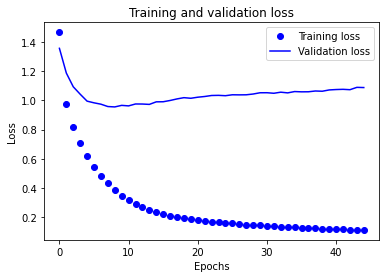

In [28]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(45)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Step 6. 모델 평가하기

### encoder

In [29]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 512)         2391552   
_________________________________________________________________
masking (Masking)            (None, None, 512)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 1024), (None, 102 6295552   
Total params: 8,687,104
Trainable params: 8,687,104
Non-trainable params: 0
_________________________________________________________________


### decoder

In [30]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_units,))
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# embedding layer정의
dec_emb_test = Embedding(fra_vocab_size,hidden_units)(decoder_inputs)
# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
decoder_outputs_test, state_h_test, state_c_test = decoder_lstm(dec_emb_test, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states_test = [state_h_test, state_c_test]

decoder_outputs_test = decoder_softmax_layer(decoder_outputs_test)

In [31]:
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs_test] + decoder_states_test)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 1024)   8348672     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1024)]       0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1024)]       0                                            
____________________________________________________________________________________________

In [32]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [33]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0]= fra2idx['\t']

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += " "+sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0]= sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [34]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['\t']) and i!=fra2idx['\n']):
            temp = temp + idx2fra[i] + ' '
    return temp

In [35]:
from googletrans import Translator

# Translator 클래스 객체 선언 
translator = Translator()

In [36]:
print(translator.translate('Did you eat?', src='en', dest='ko'))

Translated(src=en, dest=ko, text=밥은 먹었 니?, pronunciation=bab-eun meog-eoss ni?, extra_data="{'confiden...")


In [37]:
print(translator.translate('Tu as mange ?', src='fr', dest='ko'))

Translated(src=fr, dest=ko, text=당신은 먹었습니까?, pronunciation=dangsin-eun meog-eossseubnikka?, extra_data="{'confiden...")


In [38]:
for seq_index in [10000,15000,20000,25000,28000]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq2src(encoder_input_train[seq_index]))
  print(translator.translate(seq2src(encoder_input_train[seq_index]), src='en', dest='ko'))
    
  print("정답문장 :",seq2tar(decoder_input_train[seq_index]))
  print(translator.translate(seq2tar(decoder_input_train[seq_index]), src='fr', dest='ko'))
    
  print("번역문장 :",decoded_sentence[1:-5])
  print(translator.translate(decoded_sentence[:-5],src="fr", dest='ko'))
 
  print("-"*50)

입력문장 : have you eaten ? 
Translated(src=en, dest=ko, text=식사하셨나요 ?, pronunciation=sigsahasyeossnayo ?, extra_data="{'confiden...")
정답문장 : avez vous mange ? 
Translated(src=fr, dest=ko, text=식사하셨나요 ?, pronunciation=sigsahasyeossnayo ?, extra_data="{'confiden...")
번역문장 : avez vous ? 
Translated(src=fr, dest=ko, text=얻었 니 ?, pronunciation=eod-eoss ni ?, extra_data="{'confiden...")
--------------------------------------------------
입력문장 : it s my problem . 
Translated(src=en, dest=ko, text=그것은 내 문제입니다., pronunciation=geugeos-eun nae munjeibnida., extra_data="{'confiden...")
정답문장 : c est mon probleme . 
Translated(src=fr, dest=ko, text=그것이 내 문제입니다., pronunciation=geugeos-i nae munjeibnida., extra_data="{'confiden...")
번역문장 : c est ! la tem
Translated(src=fr, dest=ko, text=그것은이다 !템, pronunciation=geugeos-eun-ida ! tem, extra_data="{'confiden...")
--------------------------------------------------
입력문장 : please stay here . 
Translated(src=en, dest=ko, text=여기에 머물러주세요., pronunciation=yeogie me

In [39]:
for seq_index in [3, 50, 100,150,500]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq2src(encoder_input_test[seq_index]))
  print(translator.translate(seq2src(encoder_input_test[seq_index]), src='en', dest='ko'))
    
  print("정답문장 :",seq2tar(decoder_input_test[seq_index]))
  print(translator.translate(seq2tar(decoder_input_test[seq_index]), src='fr', dest='ko'))
    
  print("번역문장 :",decoded_sentence[1:-5])
  print(translator.translate(decoded_sentence[:-5],src="fr", dest='ko'))
 
  print("-"*50)

입력문장 : i want my key back . 
Translated(src=en, dest=ko, text=나는 내 키를 다시 원한다., pronunciation=naneun nae kileul dasi wonhanda., extra_data="{'confiden...")
정답문장 : je veux que vous me rendiez ma cle . 
Translated(src=fr, dest=ko, text=나는 당신이 내 열쇠를 돌려주기를 바랍니다., pronunciation=naneun dangsin-i nae yeolsoeleul dollyeojugileul balabnida., extra_data="{'confiden...")
번역문장 : je je mon ma 
Translated(src=fr, dest=ko, text=나는 나의 내이다, pronunciation=naneun naui naeida, extra_data="{'confiden...")
--------------------------------------------------
입력문장 : i was almost right . 
Translated(src=en, dest=ko, text=나는 거의 옳았다., pronunciation=naneun geoui olh-assda., extra_data="{'confiden...")
정답문장 : j avais presque raison . 
Translated(src=fr, dest=ko, text=나는 거의 옳았다., pronunciation=naneun geoui olh-assda., extra_data="{'confiden...")
번역문장 : j m que que l
Translated(src=fr, dest=ko, text=J m, pronunciation=J m, extra_data="{'confiden...")
--------------------------------------------------
입력문장 : i was very

# 회고 

* [주의점]
> 1. decode_sequence 함수에서  decoded_sentence += " "+sampled_char 구문 주의할것
>> "" 사이에 공백 필요! 
>> 만약 없으면, 단어형태로 뭉쳐서 나옴
>>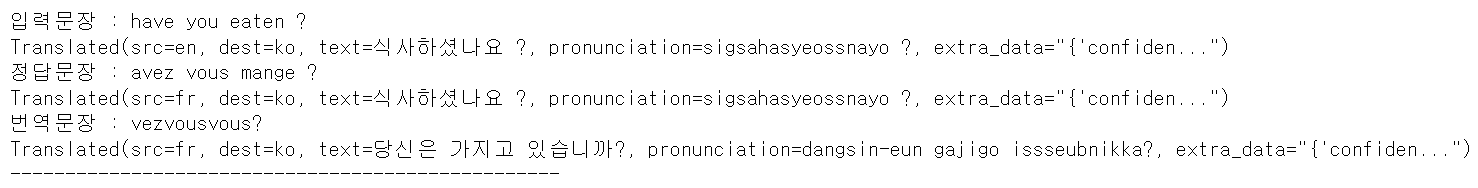
>> "" 공백이 있을경우
>>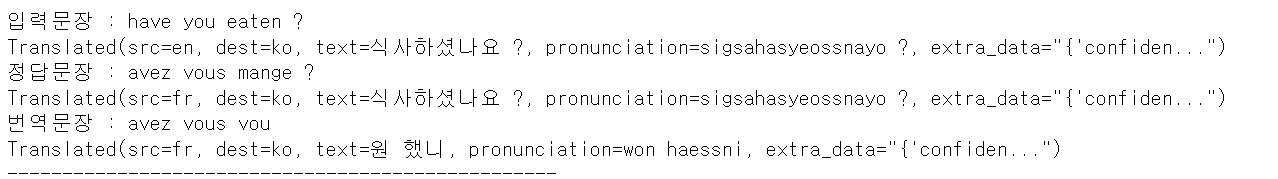

* [유용한 tip]

 **번역된 문장을 한글로 보고싶을때!**
 * 구글번역 API 사용하기
 * 커널창(4.0.0버전 사용하기) :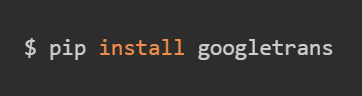
 * 코드창 :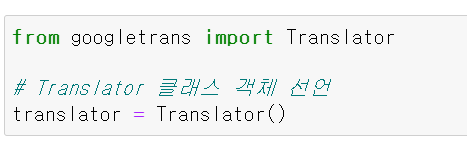
 * 참고자료 : https://py-googletrans.readthedocs.io/en/latest/

번역된 문장들의 출력값을 보면 정답(taget data = 프랑스어)과 일부 맞고 정확한 번역을 하지 못하는 부분을 볼 수 있다. 
이는. 모델 파리미터 ( 깊이, 은닉층, epochs )등 및 조절하는 와중에 train data에 대한 학습은 잘되고 test data에 대한 결과치를 봤을 경우 모델 오버피팅이 일어나지 않았을까 하는 의구심이 들었으며, 


[embedding_dim = 512,
hidden_units = 1024, epochs=45]
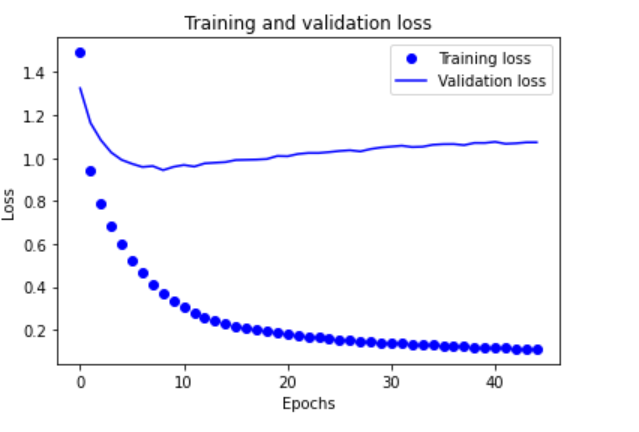

[embedding_dim = 256,
hidden_units = 256, epochs=45]
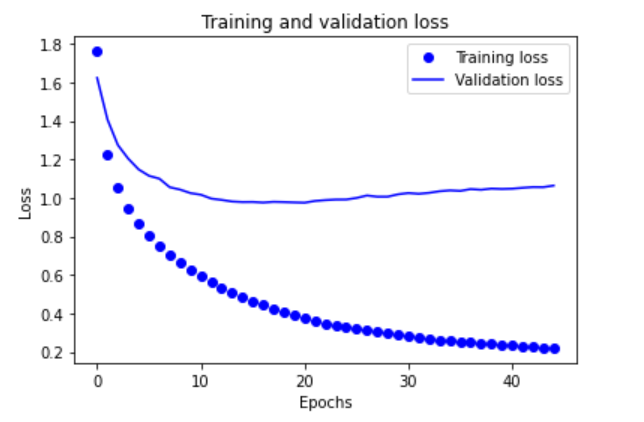

[embedding_dim = 64,
hidden_units = 128, epochs=45]
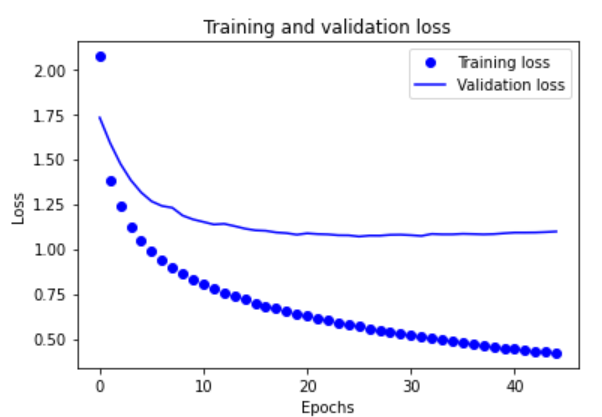

처음에 출력값이 문장형태가 아닌 단어형태(뜻을 알수 없는 단어: 단어장에도 없는 단어)로 나와 전처리 구간의 문제점인가 하여 
전처리 구간에서 프랑스어 악센트 제거하는 구간의 문제인가 싶어 악센트 제거하지 않고 정규식을 통해 전처리 하는 방법으로 진행했지만 여전히 똑같은 현상이 반복되었으며, 이후 모델링의 문제인가 싶어 인코더, 디코더 설계부터 다시 뜯어보면서 변수오류인가 하고 몇번을 시도했지만 똑같은 현상이 반복되는 찰나,출력값은, 정답지와 유사한 느낌의 단어인듯한 느낌이 들어,  decode_sequence 함수를 보던 중 공백을 넣어주는 시도 끝에 문장형으로 출력하는 결과를 만들어 내었다.

이번 프로젝트는 한 오류로 인해 인코더 디코더를 자세히 뜯어볼 수 있는 시간이였고, 코딩시 모든 변수와 안의 내용을 섬세하게 검토해나가면서 짜야한다는 점을 다시 한번 느낄 수 있었습니다
또한, 역시 오류문이 생기면 많이 배울 수 있다는 점도 체감한 프로젝트!